# Recommendation system for arXiv manuscripts by Peter Boross

In [1]:
import sys
import time
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import warnings
import time
import json
import arxiv
import sqlite3
import urllib.request as libreq
import re
from collections import Counter
import unidecode
import itertools
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, recall_score, plot_roc_curve, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import wordcloud

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /Users/bope/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Helper functions

In [2]:
def get_authors_FLast(authors):
    """  """
    r = []
    for author in authors:
        if len(author[1]) == 0: r.append(unidecode.unidecode(author[0]))
        else: r.append(unidecode.unidecode(author[1][0]+author[0]))    
    return ' '.join(r)

def get_authors_FLast_arxivapi(authors):
    r = []
    for authorv in authors:
        author = authorv.split(' ')
        r.append(unidecode.unidecode(author[0][0]+author[-1]))    
    return ' '.join(r)

def get_authors_FdotLastcomma(authors):
    r = []
    for author in authors:
        authorv = author.split(' ')
        r.append(unidecode.unidecode(' '.join([x[0]+'.' for x in authorv[0:-1]])+' '+authorv[-1]))
    return ', '.join(r)

def progress_bar(relevance):
    s = 100-int(100-100*relevance/5)
    if s > 14:
        if s > 17:
            color = 'red'
        else:
            color = 'orange'
    else:
        color = 'yellow'
    return '|<font color="'+color+'">'+'█'*s+'</font>'+'-'*(20-s)+'|'

def print_score_oneline(scores, type, train):
    extra_space = 9
    string = ''
    if train:
        string = 'train '+type+' '*(extra_space-len(type))+' = '+'{:.1f}%\t\t'.format(100*np.mean(scores['train_'+type]))
    string += 'test '+type+' '*(extra_space-len(type))+' = '+'{:.1f}%'.format(100*np.mean(scores['test_'+type])) 
    print(string)

def print_score(scores, types, train=False):
    [print_score_oneline(scores, score, train) for score in types]

def roc_curve_cv_plot(X, y, cvsplitter, estimators):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cvsplitter.split(X,y)):
        viz = plot_roc_curve(estimators[i], X.iloc[test], [y[idx] for idx in test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

def precision_recall_cv_plot(X, y, cvsplitter, estimators):
    precisions = []
    recalls = []
    mean_thresholds = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cvsplitter.split(X,y)):
        y_predict_proba = estimators[i].predict_proba(X.iloc[test])[:, 1]
        precision, recall, thresholds = precision_recall_curve([y[idx] for idx in test], y_predict_proba)
        interp_precision = np.interp(mean_thresholds, thresholds, precision[0:-1])
        interp_recall = np.interp(mean_thresholds, thresholds, recall[0:-1])
        precisions.append(interp_precision)
        recalls.append(interp_recall)
        ax.plot(mean_thresholds, interp_precision, color='b', lw=1, alpha=.3)
        ax.plot(mean_thresholds, interp_recall, color='r', lw=1, alpha=.3)

    mean_precision = np.mean(precisions, axis=0)
    mean_recall = np.mean(recalls, axis=0)

    ax.plot(mean_thresholds, mean_precision, color='b', lw=2, alpha=.8, label='Precision')
    ax.plot(mean_thresholds, mean_recall, color='r', lw=2, alpha=.8, label='Recall')

    std_precision = np.std(precisions, axis=0)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)
    ax.fill_between(mean_thresholds, precision_lower, precision_upper, color='grey', alpha=.2)

    std_recall = np.std(recalls, axis=0)
    recall_upper = np.minimum(mean_recall + std_recall, 1)
    recall_lower = np.maximum(mean_recall - std_recall, 0)
    ax.fill_between(mean_thresholds, recall_lower, recall_upper, color='grey', alpha=.2)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Precision/recall-threshold curves",
        xlabel='Threshold', ylabel='Precision/recall')
    ax.legend(loc="center left")
    ax.grid()
    plt.show()

class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', '(', ')', '{', '}', '?', '!']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

regex = re.compile('[^a-zA-Z0-9]')
def clear_latex(string):
    s = string.lower()
    #s = re.sub('\\$_{', '_', s)
    #s = re.sub('}\\$', '', s)
    #s = re.sub('\\$', '', s)
    ##s = re.sub('\\$.+?\\$', '', s)
    s = re.sub('\n', ' ', s)
    s = regex.sub(' ', s)
    return s

### Define categories

In [3]:
categories = {'cond-mat', 'quant-ph', 'cond-mat.mes-hall', 'cond-mat.supr-con', 'cond-mat.mtrl-sci', 'cond-mat.str-el', 'cond-mat.other'}

### Load manuscripts from arXiv JSON by Kaggle

In [4]:
manuscripts = []

with open("data/arxiv-metadata-oai-snapshot.json", "r") as f:
    for l in f:
        d = json.loads(l)
        if categories & set(d['categories'].split(' ')):
            d['authors_FLast'] = get_authors_FLast(d['authors_parsed'])
            manuscripts.append(d)

manuscripts_df = pd.DataFrame().from_records(manuscripts)

print('number of papers =',len(manuscripts))

number of papers = 317761


### Find manuscript of the authors

In [5]:
authors = ['PBoross','LOroszlany','APalyi','JAsboth','GSzechenyi','ZZimboras']

ownids = list(manuscripts_df[manuscripts_df["authors_FLast"].str.contains('|'.join(authors))]['id'])

print('number of papers of the authors =',len(ownids))

number of papers of the authors = 136


### Find cited papers by prophy.science

In [6]:
citedids = ownids.copy()

for id in ownids:
    with libreq.urlopen('https://www.prophy.science/api/arxiv/' + id) as url:
        refs1manuscript = json.loads(url.read())
    citedids.extend([ref['arxivId'] for ref in refs1manuscript['references'] if ref['arxivId'] != None])

citedidscounted = sorted(Counter(citedids).items(), key=lambda pair: pair[1], reverse=True)
citedids = [entry[0] for entry in citedidscounted]
counts = [entry[1] for entry in citedidscounted]
citedidscounteddict = dict(zip(citedids, counts))

print('number of cited papers of the authors =',len(citedidscounted))

number of cited papers of the authors = 2624


### Make training dataset and write it out

In [7]:
cited_df = manuscripts_df[manuscripts_df['id'].isin(citedids)][['abstract','title','authors_FLast','id']].replace(citedidscounteddict).rename(columns = {'id': 'citation'})
cited_df['cited'] = True

print('number of cited papers which in the selected categories =',len(cited_df))

notcited_df = manuscripts_df[manuscripts_df['id'].isin(citedids) == False][['abstract','title','authors_FLast']]#.sample(n = 1*len(cited_df))
notcited_df['citation'] = 0
notcited_df['cited'] = False

print('number of non-cited papers which in the selected categories =',len(notcited_df))

all_df = pd.concat([cited_df, notcited_df])

cited_df.to_csv('data/traindataset_cited.csv')
notcited_df.to_csv('data/traindataset_notcited.csv')
all_df.to_csv('data/traindataset.csv')

number of cited papers which in the selected categories = 2490
number of non-cited papers which in the selected categories = 315271


### Split to X and y

In [8]:
cited_df = pd.read_csv('data/traindataset_cited.csv', index_col=0)
notcited_df = pd.read_csv('data/traindataset_notcited.csv', index_col=0)
all_df = pd.read_csv('data/traindataset.csv', index_col=0)

X = all_df[['authors_FLast','title','abstract']]
y = list(all_df['cited'])

### Build the model and make cross validation

In [9]:
tokenizer = LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

authors_feature = 'authors_FLast'
authors_transformer = CountVectorizer(lowercase=False, max_features=250)

title_feature = 'title'
title_transformer = TfidfVectorizer(preprocessor=clear_latex,
                                    stop_words=token_stop,
                                    tokenizer=tokenizer,
                                    ngram_range=(1,3),
                                    max_features=1000)

abstract_feature = 'abstract'
abstract_transformer = TfidfVectorizer(preprocessor=clear_latex,
                                       stop_words=token_stop,
                                       tokenizer=tokenizer,
                                       ngram_range=(1,3),
                                       max_features=2000)

preprocessor = ColumnTransformer(
    transformers=[
        ('authors_FLast', authors_transformer, authors_feature),
        ('title', title_transformer, title_feature),
        ('abstract', abstract_transformer, abstract_feature)
    ])

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=0)

#classifier = Pipeline(steps=[('preprocessor', preprocessor),
#                             ('balancer', RandomOverSampler()),
#                             ('classifier', MultinomialNB())])

classifier = Pipeline(steps=[('undersampler', undersampler),
                             ('oversampler', RandomOverSampler()),
                             ('preprocessor', preprocessor),
                             ('classifier', MultinomialNB())])

cvsplitter = StratifiedShuffleSplit(n_splits=3, random_state=0)

scores = cross_validate(classifier, X, y, cv=cvsplitter,
                        scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'),
                        #return_train_score=True,
                        return_estimator=True,
                        n_jobs=-1)

test accuracy  = 84.8%
test precision = 3.8%
test recall    = 76.0%
test f1        = 7.3%
test roc_auc   = 88.7%


/Users/bope/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/bope/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/bope/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


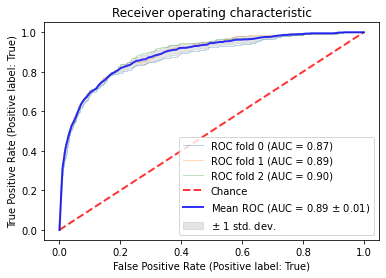

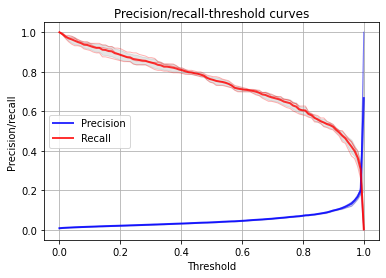

In [10]:
print_score(scores, ['accuracy','precision','recall','f1','roc_auc'], train=False)
roc_curve_cv_plot(X, y, cvsplitter, scores['estimator'])
precision_recall_cv_plot(X, y, cvsplitter, scores['estimator'])

### Fit on the whole dataset and save the classifier

In [11]:
classifier.fit(X, y);

filename = 'data/model.sav'
pickle.dump(classifier, open(filename, 'wb'))

/Users/bope/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### Make a query and predict

In [12]:
filename = 'data/model.sav'
classifier = pickle.load(open(filename, 'rb'))

days = 7
delta = timedelta(days = days)
catstr = '+OR+'.join(['cat:'+x for x in categories])
client = arxiv.Client()
nquery = 500
startquery = 0
lastquery = nquery
latestdate = False
predicted_df = pd.DataFrame(columns = ['id','published','authors_FdotLastcomma','authors_FLast', 'title', 'abstract'])

while lastquery == nquery:
    feedparser = client._parse_feed(url='http://export.arxiv.org/api/query?search_query='+catstr+'&start='+str(startquery)+'&max_results='+str(nquery)+'&sortBy=submittedDate')
    if len(feedparser.entries) == 0:
        warnings.warn("Warning...........arXiv api provides 0 entry")
    lastquery = 0
    for entry in feedparser.entries:
        if not(latestdate): latestdate = datetime.strptime(entry.published[0:10],'%Y-%m-%d')
        if latestdate - datetime.strptime(entry.published[0:10],'%Y-%m-%d') < delta:
            lastquery += 1
            predicted_df = predicted_df.append({
                'id' : entry.id,
                'authors_FdotLastcomma' : get_authors_FdotLastcomma([author['name'] for author in entry.authors]),
                'authors_FLast' : get_authors_FLast_arxivapi([author['name'] for author in entry.authors]),
                'title' : entry.title.replace('\n', ' '),
                'abstract' : entry.summary.replace('\n', ' '),
                'published': datetime.strptime(entry.published[0:10],'%Y-%m-%d')
                            }, ignore_index = True)
    startquery += nquery
    time.sleep(5)

Xnew = predicted_df[['authors_FLast','title','abstract']]

predicted_df['relevance'] = [x[1] for x in classifier.predict_proba(Xnew)]
print('number of the requested papers = ',predicted_df.shape[0])

predicted_df[['id','published','authors_FdotLastcomma','title','abstract','relevance']].sort_values(by=['relevance'],ascending=False).head(5)

/Users/bope/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


number of the requested papers =  415


,id,published,authors_FdotLastcomma,title,abstract,relevance
73,http://arxiv.org/abs/2107.02789v2,2021-07-06,"P. Chandarana, N. N. Hegade, K. Paul, F. Albar...",Digitized-counterdiabatic quantum approximate ...,The quantum approximate optimization algorithm...,0.999850
347,http://arxiv.org/abs/2107.00732v1,2021-07-01,"B. Tariq, X. Hu",Impact of the valley orbit coupling on exchang...,The presence of degenerate conduction band val...,0.998834
358,http://arxiv.org/abs/2107.00628v1,2021-07-01,"X. Xue, M. Russ, N. Samkharadze, B. Undseth, A...",Computing with spin qubits at the surface code...,High-fidelity control of quantum bits is param...,0.998716
195,http://arxiv.org/abs/2107.01860v1,2021-07-05,"C. D. Marciniak, T. Feldker, I. Pogorelov, R. ...",Optimal metrology with variational quantum cir...,Cold atoms and ions exhibit unparalleled perfo...,0.997587
154,http://arxiv.org/abs/2107.02194v1,2021-07-05,"M. B. Hastings, J. Haah",Dynamically Generated Logical Qubits,We present a quantum error correcting code wit...,0.995214


### Write predictions into 'manuscripts.db'

In [ ]:
tosql_df = predicted_df[['id','published','authors_FdotLastcomma','title','abstract','relevance']].rename(columns = {"authors_FdotLastcomma": "authors"})

conn = sqlite3.connect('data/manuscripts.db')
c = conn.cursor()

c.execute('CREATE TABLE IF NOT EXISTS manuscripts (id, published, authors, title, abstract, relevance)')
conn.commit()

tosql_df.to_sql('manuscripts', conn, if_exists = 'replace', index = False)

### Write predictions into 'manuscripts.html'

In [13]:
tohtml_df = predicted_df[['id','published','authors_FdotLastcomma','title','abstract','relevance']].rename(columns = {"authors_FdotLastcomma": "authors"})

day = False
html = '<ul>\n'
html += '<hr>\n'
for idx, row in tohtml_df[tohtml_df['relevance']>0.5].sort_values(by=['published','relevance'],ascending=False).iterrows():
    if day != row['published']:
        html += '<div class="date">'+row['published'].strftime('%-d %B, %Y')+'</div>\n'
        html += '<hr>\n'
        day = row['published']
    html += '<li>\n'
    html += '<a href="'+row['id']+'">arXiv:'+row['id'].split('http://arxiv.org/abs/')[-1][:-2]+'</a>\n'
    html += '<div class="relevance"><b>Relevance:</b>'
    html += '<font style="font-family:courier, monospace">'+progress_bar(row['relevance'])+'</font>'
    html += str(round(100*row['relevance'],1))+'%</div>\n'
    html += '<div class="title"><b>Title:</b> '+row['title']+'</div>\n'
    html += '<div class="authors_head"><b>Authors:</div></b> '
    html += '<div class="authors"><i>'+row['authors']+'</i></div>\n'
    html += '<div class="abstract_head"><b>Abstract:</b></div>\n'
    html += '<div class="abstract">'+row['abstract']+'</div>\n'
    html += '<br>\n'
    html += '</li>\n'
    html += '<hr>\n'
html += '</ul>'

with open("data/template.html", "r") as file:
    template = file.read()

html = template.replace("***", html)

with open("data/manuscripts.html", "w") as file:
        file.write(html)

In [15]:
abstract_words = classifier['preprocessor'].transformers_[2][1].get_feature_names()
abstract_idfs = classifier['preprocessor'].transformers_[2][1].idf_
abstract_tfs = classifier['preprocessor'].transformers_[2][1].transform(cited_df.abstract).sum(axis=0)
abstract_tfs = np.squeeze(np.asarray(abstract_tfs))

In [16]:
sorted(zip(abstract_words,abstract_idfs), key = lambda x: x[1])[0:10]

[('quantum', 1.7003108341251305),
 ('state', 1.815759244635843),
 ('two', 1.9819715673364018),
 ('system', 2.0694336292971),
 ('show', 2.1251447220725868),
 ('field', 2.1360510368010983),
 ('spin', 2.2054997422584215),
 ('result', 2.3462934199380108),
 ('electron', 2.3496203899219474),
 ('effect', 2.361664988253768)]

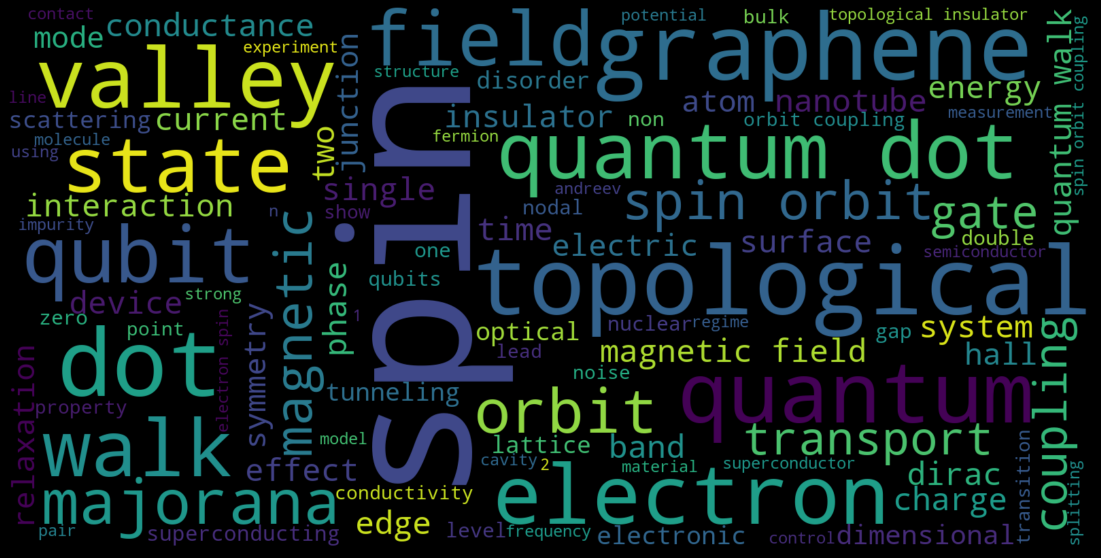

In [17]:
abstract_tfidfs = dict(zip(abstract_words,abstract_tfs*abstract_idfs))
cloud = wordcloud.WordCloud(background_color="black",
                            max_words=100,
                            width=1600,
                            height=800).generate_from_frequencies(abstract_tfidfs)

plt.figure(figsize=[20,10], facecolor='k')
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
sorted(zip(abstract_words,abstract_tfs*abstract_idfs), key = lambda x: x[1],reverse=True)[0:100]